In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import shutil
# shutil.move('/content/gender_human_datection.pt', '/content/drive/MyDrive/facecup_models')
# shutil.move('/content/gender_human_datection.pt', '/content/drive/MyDrive/facecup_models')

In [ ]:
# !pip install timm
# import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unrar x /content/drive/MyDrive/facecup/train.rar /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/train/132/132_2.jpg                                   9%  OK 
Extracting  /content/train/132/132_3.jpg                                   9%  OK 
Creating    /content/train/133                                        OK
Extracting  /content/train/133/133_1.jpg                                   9%  OK 
Extracting  /content/train/133/133_10.jpg                                  9%  OK 
Extracting  /content/train/133/133_11.jpg                                  9%  OK 
Extracting  /content/train/133/133_14.jpg                                  9%  OK 
Extracting  /content/train/133/133_16.jpg                                  9%  OK 
Extracting  /content/train/133/133_2.jpg                                   9%  OK 
Extracting  /content/train/133/133_3.jpg                                   9%  OK 
Extracting  /content/train/133/133_4.jpg        

In [ ]:
train_dir = "train"
image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
class_image_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        num_images = sum(1 for file in os.listdir(class_path) if file.lower().endswith(image_extensions))
        class_image_counts[class_name] = num_images

for class_name, count in class_image_counts.items():
    print(f"Class '{class_name}' has {count} images.")

Class '440' has 12 images.
Class '16' has 3 images.
Class '282' has 16 images.
Class '381' has 4 images.
Class '410' has 6 images.
Class '249' has 8 images.
Class '204' has 3 images.
Class '74' has 10 images.
Class '259' has 9 images.
Class '126' has 11 images.
Class '102' has 5 images.
Class '384' has 4 images.
Class '183' has 3 images.
Class '422' has 6 images.
Class '62' has 11 images.
Class '269' has 6 images.
Class '457' has 6 images.
Class '451' has 6 images.
Class '435' has 16 images.
Class '446' has 6 images.
Class '345' has 14 images.
Class '132' has 3 images.
Class '127' has 7 images.
Class '124' has 22 images.
Class '253' has 8 images.
Class '315' has 23 images.
Class '445' has 12 images.
Class '28' has 19 images.
Class '148' has 5 images.
Class '290' has 7 images.
Class '142' has 6 images.
Class '316' has 4 images.
Class '230' has 17 images.
Class '307' has 6 images.
Class '182' has 20 images.
Class '351' has 11 images.
Class '419' has 3 images.
Class '38' has 26 images.
Cl

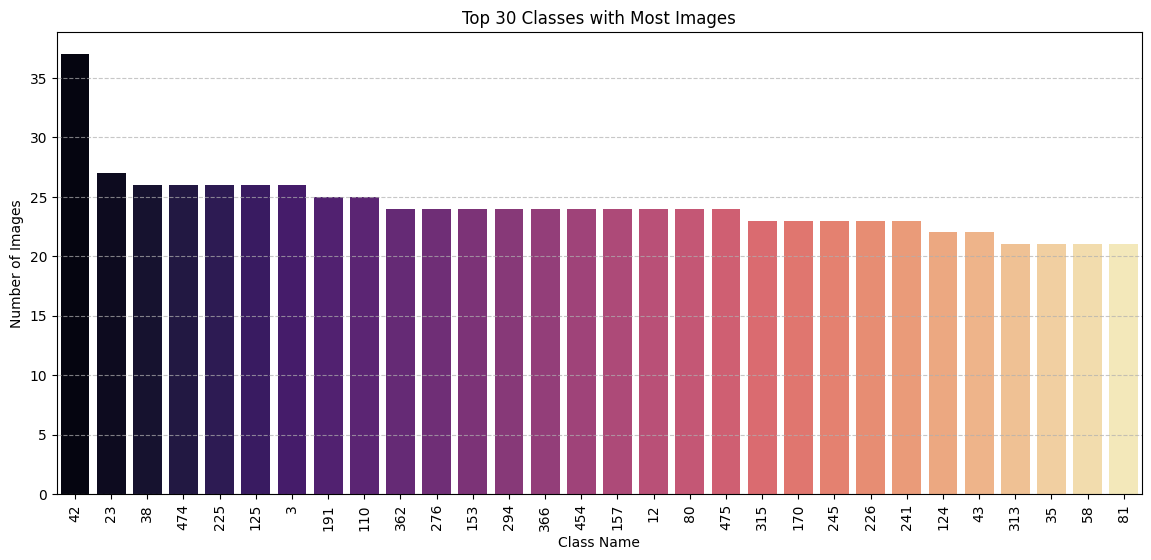

In [ ]:
import seaborn as sns

train_dir = "train"

image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
class_image_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        num_images = sum(1 for file in os.listdir(class_path) if file.lower().endswith(image_extensions))
        class_image_counts[class_name] = num_images

sorted_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)

top_n = 30
top_classes, top_counts = zip(*sorted_classes[:top_n])

plt.figure(figsize=(14, 6))

sns.barplot(x=list(top_classes), y=list(top_counts), palette="magma")
plt.xticks(rotation=90)
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.title(f"Top {top_n} Classes with Most Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.savefig("top_classes_chart.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])


transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

In [ ]:
class_names=sorted(os.listdir('/content/train'))
print(class_names)
print(len(class_names))
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N))
reverse_mapping=dict(zip(N,class_names))

['0', '1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '225', '226', '227', '228', '22

In [ ]:
path_label=[]
for dirname, _, filenames in os.walk('/content/train'):
    for filename in filenames:
        if filename[-4:]=='.jpg' and dirname.split('/')[-1] in class_names:
            path=os.path.join(dirname, filename)
            label=dirname.split('/')[-1]
            path_label+=[(path,normal_mapping[label])]

In [ ]:
path_label

[('/content/train/440/440_18.jpg', 380),
 ('/content/train/440/440_6.jpg', 380),
 ('/content/train/440/440_5.jpg', 380),
 ('/content/train/440/440_12.jpg', 380),
 ('/content/train/440/440_17.jpg', 380),
 ('/content/train/440/440_1.jpg', 380),
 ('/content/train/440/440_4.jpg', 380),
 ('/content/train/440/440_2.jpg', 380),
 ('/content/train/440/440_14.jpg', 380),
 ('/content/train/440/440_11.jpg', 380),
 ('/content/train/440/440_7.jpg', 380),
 ('/content/train/440/440_10.jpg', 380),
 ('/content/train/16/16_5.jpg', 68),
 ('/content/train/16/16_2.jpg', 68),
 ('/content/train/16/16_3.jpg', 68),
 ('/content/train/282/282_12.jpg', 204),
 ('/content/train/282/282_28.jpg', 204),
 ('/content/train/282/282_29.jpg', 204),
 ('/content/train/282/282_31.jpg', 204),
 ('/content/train/282/282_1.jpg', 204),
 ('/content/train/282/282_17.jpg', 204),
 ('/content/train/282/282_18.jpg', 204),
 ('/content/train/282/282_19.jpg', 204),
 ('/content/train/282/282_8.jpg', 204),
 ('/content/train/282/282_7.jpg', 20

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, path_label, transform=None):
        self.path_label = path_label
        self.transform = transform

    def __len__(self):
        return len(self.path_label)

    def __getitem__(self, idx):
        path, label = self.path_label[idx]
        img = Image.open(path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [ ]:
dataset = ImageDataset(path_label, transform)

In [ ]:
labels = [label for _, label in dataset.path_label]

In [ ]:
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
# mean = 0.0
# std = 0.0
# nb_samples = 0

# for data in train_loader:
#     images, _ = data
#     batch_samples = images.size(0)
#     images = images.view(batch_samples, images.size(1), -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

# print(f"Mean: {mean}")
# print(f"Std: {std}")

In [ ]:
for images, labels in train_loader:
    break
im=make_grid(images,nrow=16)

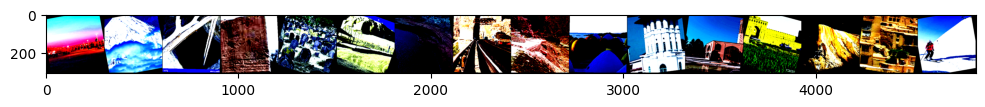

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

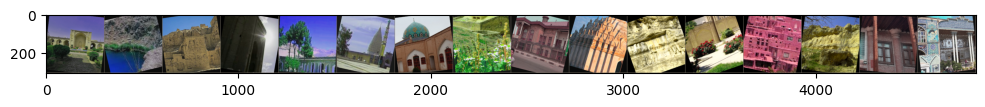

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
torch.manual_seed(42)

In [ ]:
train_loader

In [ ]:
# class PrototypicalNetwork(nn.Module):
#     def __init__(self, num_classes=488, feature_dim=2048):
#         super(PrototypicalNetwork, self).__init__()
#         self.model = models.resnet50(weights=None)
#         self.model.fc = nn.Linear(self.model.fc.in_features, feature_dim)

#     def forward_once(self, x):
#         return self.model(x)

#     def compute_prototypes(self, support_set, labels, num_classes):
#         prototypes = []
#         for c in range(num_classes):
#             class_samples = support_set[labels == c]
#             prototype = class_samples.mean(dim=0) if len(class_samples) > 0 else torch.zeros_like(support_set[0])
#             prototypes.append(prototype)
#         return torch.stack(prototypes)

#     def forward(self, support_set, support_labels, query):
#         support_features = self.forward_once(support_set)
#         query_features = self.forward_once(query)
#         prototypes = self.compute_prototypes(support_features, support_labels, num_classes=len(torch.unique(support_labels)))
#         dists = torch.cdist(query_features.unsqueeze(0), prototypes.unsqueeze(0)).squeeze(0)
#         return -dists

class SimpleEfficientNet(nn.Module):
    def __init__(self, num_classes=len(class_names), pretrained=True):
        super(SimpleEfficientNet, self).__init__()

        self.efficientnet = models.efficientnet_b6(pretrained=pretrained)

        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleEfficientNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 25
start_time = time.time()
train_losses = []
train_correct = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

for i in range(epochs):
    trn_corr = 0
    running_loss = 0.0
    total_samples = 0
    epoch_start_time = time.time()

    model.train()

    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        total_samples += y_train.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if b % 200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{b * len(X_train):6}/{len(train_loader.dataset)}]  '
                  f'loss: {loss.item():10.8f}  '
                  f'accuracy: {trn_corr.item() * 100 / total_samples:7.3f}%')

    train_losses.append(running_loss / len(train_loader))
    train_correct.append(trn_corr.item() * 100 / total_samples)
    print(f'Epoch {i+1} finished in {time.time() - epoch_start_time:.2f} seconds')
    scheduler.step()

print(f'\nTotal Training Duration: {time.time() - start_time:.0f} seconds')

epoch:  0  batch:    0 [     0/5011]  loss: 6.26120424  accuracy:   0.000%
epoch:  0  batch:  200 [  3200/5011]  loss: 5.88890076  accuracy:   1.555%
Epoch 1 finished in 401.97 seconds
epoch:  1  batch:    0 [     0/5011]  loss: 5.57030582  accuracy:  18.750%
epoch:  1  batch:  200 [  3200/5011]  loss: 4.66178513  accuracy:  17.040%
Epoch 2 finished in 396.71 seconds
epoch:  2  batch:    0 [     0/5011]  loss: 3.98563862  accuracy:  37.500%
epoch:  2  batch:  200 [  3200/5011]  loss: 3.76639318  accuracy:  29.322%
Epoch 3 finished in 391.48 seconds
epoch:  3  batch:    0 [     0/5011]  loss: 3.16568422  accuracy:  37.500%
epoch:  3  batch:  200 [  3200/5011]  loss: 1.79046786  accuracy:  41.076%
Epoch 4 finished in 395.94 seconds
epoch:  4  batch:    0 [     0/5011]  loss: 2.24175644  accuracy:  75.000%
epoch:  4  batch:  200 [  3200/5011]  loss: 2.41643667  accuracy:  51.648%
Epoch 5 finished in 386.42 seconds
epoch:  5  batch:    0 [     0/5011]  loss: 2.17112565  accuracy:  62.500%


In [ ]:
model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in train_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(y_true[0:10])
print(y_pred[0:10])

[169, 367, 165, 30, 244, 262, 259, 483, 103, 471]
[166, 367, 165, 30, 244, 262, 259, 483, 103, 471]


In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231         6
           1     0.0000    0.0000    0.0000         5
          10     0.0000    0.0000    0.0000         6
         100     0.7500    0.8571    0.8000        14
         101     0.0000    0.0000    0.0000         3
         102     0.7500    0.6000    0.6667         5
         103     0.5357    1.0000    0.6977        15
         104     0.6316    1.0000    0.7742        12
         105     0.6923    0.9000    0.7826        10
         106     0.4167    0.8333    0.5556         6
         107     1.0000    0.7895    0.8824        19
         108     0.8421    0.8889    0.8649        18
         109     0.5517    0.8889    0.6809        18
          11     1.0000    0.3333    0.5000         6
         110     1.0000    0.9200    0.9583        25
         111     0.6364    0.7778    0.7000        18
         112     0.0000    0.0000    0.0000         3
         113     0.6897    

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/efficientnet_b6.pth")

In [ ]:
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = '/content/train/1/1_3.jpg'
img = Image.open(image_path).convert('RGB')
img = transform(img)
img = img.unsqueeze(0)
img = img.to(device)
model = model.to(device)

with torch.no_grad():
    output = model(img)
    predicted_class = torch.argmax(output, dim=1).item()

print(f'Predicted class: {class_names[predicted_class]}')

Predicted class: 1


In [ ]:
!pip install ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

In [ ]:
yolo_model = YOLO("/content/drive/MyDrive/facecup/gender_human_datection.pt")

class SimpleEfficientNet(nn.Module):
    def __init__(self, num_classes=len(class_names), pretrained=True):
        super(SimpleEfficientNet, self).__init__()

        self.efficientnet = models.efficientnet_b6(pretrained=pretrained)

        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399', '400', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412', '413', '414', '415', '416', '417', '418', '419', '420', '421', '422', '423', '424', '425', '426', '427', '428', '429', '430', '431', '432', '433', '434', '435', '436', '437', '438', '439', '440', '441', '442', '443', '444', '445', '446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model = SimpleEfficientNet()
classification_model.load_state_dict(torch.load("/content/drive/MyDrive/efficientnet_b6.pth", map_location=device))
classification_model = classification_model.to(device)
classification_model.eval()

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def process_folder(folder_path, output_csv):
    data = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        if not os.path.isfile(image_path):
            continue

        male_count = 0
        female_count = 0

        # YOLO inference
        yolo_results = yolo_model(image_path)
        for result in yolo_results:
            for box in result.boxes:
                cls = int(box.cls)  # Class index
                if cls == 0:  # Assuming 0 represents 'male'
                    male_count += 1
                elif cls == 1:  # Assuming 1 represents 'female'
                    female_count += 1

        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = classification_model(img)
            probabilities = F.softmax(output, dim=1).cpu().numpy().flatten()

        row = {
            'path': image_name,
            'males': male_count,
            'females': female_count
        }

        for idx, prob in enumerate(probabilities):
            row[idx] = float(f"{prob}")

        data.append(row)

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)

process_folder("/content/test", "/content/drive/MyDrive/Submission-efficientnet_b6.csv")

Streaming output truncated to the last 5000 lines.
image 1/1 /content/test/eNwDUTofsR.jpg: 640x480 (no detections), 13.1ms
Speed: 4.4ms preprocess, 13.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/test/CcHSrVztb5.jpg: 416x640 1 female, 6 males, 14.2ms
Speed: 3.4ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/test/vsKjXJvOLg.jpg: 480x640 (no detections), 14.2ms
Speed: 3.8ms preprocess, 14.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/test/fa1ZPUOGOy.jpg: 320x640 (no detections), 19.4ms
Speed: 2.7ms preprocess, 19.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/test/SLbZOFb5Oj.jpg: 448x640 1 female, 18.0ms
Speed: 3.8ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/test/ppcaN92ocl.jpg: 448x640 (no detections), 15.6ms
Speed: 4.0ms preprocess, 15.6ms 